## Notebook para EDA utilizando o dataset _auto-mpg_
> Este dataset é um dos conhecidos entre praticantes de DS/ML por ser simples para iniciantes, porém que nos permite entender as limitações de alguns algoritmos. O intuito deste notebook é entender um pouco da estrutura do dataset.
Disponível em: http://archive.ics.uci.edu/ml/datasets/Auto+MPG

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline
from scipy import stats

In [2]:
df = pd.read_csv('auto-mpg.csv',index_col='car name')

In [3]:
print(df.head(),'\n\n',df.describe())
#horsepower is not appearing and is numerical

                            mpg  cylinders  displacement horsepower  weight  \
car name                                                                      
chevrolet chevelle malibu  18.0          8         307.0        130    3504   
buick skylark 320          15.0          8         350.0        165    3693   
plymouth satellite         18.0          8         318.0        150    3436   
amc rebel sst              16.0          8         304.0        150    3433   
ford torino                17.0          8         302.0        140    3449   

                           acceleration  model year  origin  
car name                                                     
chevrolet chevelle malibu          12.0          70       1  
buick skylark 320                  11.5          70       1  
plymouth satellite                 11.0          70       1  
amc rebel sst                      12.0          70       1  
ford torino                        10.5          70       1   

          

In [4]:
df.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight            int64
acceleration    float64
model year        int64
origin            int64
dtype: object

_horsepower_ se apresenta como do tipo _objeto_ quando deveria se apresentar como _int_. Vamos procurar por padrões que nao sejam numéricos.

In [5]:
df[~df['horsepower'].str.contains('[\d]+')]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
car name,,,,,,,,
ford pinto,25.0,4,98.0,?,2046,19.0,71,1
ford maverick,21.0,6,200.0,?,2875,17.0,74,1
renault lecar deluxe,40.9,4,85.0,?,1835,17.3,80,2
ford mustang cobra,23.6,4,140.0,?,2905,14.3,80,1
renault 18i,34.5,4,100.0,?,2320,15.8,81,2
amc concord dl,23.0,4,151.0,?,3035,20.5,82,1


Alguns kernels existentes optam por remover estes valores, neste notebook a título de exploração vamos testar a utilização de regressão linear como método para imputar valores.

Uma abordagem mais sensível para o caso de haverem mais dados que se assemelhassem a estes seria utilizar KNN regressores considerando que haveria maior quantidade de pontos dispersos próximos destas 6 observações

# A ideia agora é testar o knn regressor e comparar com a regressão para imputar valores: ler o artigo do analythics vidhya

O KNN talvez seja bem mais complexo para imputação pois variáveis categóricas como país deveriam para melhor serem alimentadas ao modelo serem One Hot Code Labeling(pd.get_dummy). Mesmo com one hot encoding a regressão linear parece ter melhor pontuação na validação cruzada então optamos por imputação via lin_reg

In [222]:
train = df[df['horsepower'] != '?']
train['horsepower'] = train['horsepower'].astype('float')

df_to_fill = df[df['horsepower'] == '?']
xz = df_to_fill[df_to_fill.columns.difference(['horsepower'])]
xz['origin'] = pd.get_dummies(xz['origin'])

C:\Users\Bronze\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Bronze\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [228]:
from sklearn.model_selection import train_test_split, KFold,  cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression


def KNN(pred):
    train['origin'] = pd.get_dummies(train['origin'])
    
    X = train[train.columns.difference(['horsepower'])]
                                       
    X_train,X_test,y_train,y_test = train_test_split(
        X,train['horsepower'],test_size = 0.2)

    scaler = MinMaxScaler(feature_range=(0, 1))

    #scalling all the DataFrames
    X_train = pd.DataFrame(scaler.fit_transform(X_train))
    X_test = pd.DataFrame(scaler.fit_transform(X_test))
    pred = pd.DataFrame(scaler.transform(pred))

    outer_cv = KFold(n_splits=5, shuffle=True)

    knn= KNeighborsRegressor(n_neighbors=3,weights='distance')
    knn.fit(X_train,y_train)
    
    nested_score = cross_val_score(knn, X=X_test, y=y_test, cv=outer_cv)
    print('Mean:',nested_score.mean(),'+/-',nested_score.std())

    y_pred = knn.predict(pred)
    return y_pred

KNN(xz)

Mean: 0.8812937654008403 +/- 0.03438570838501639


C:\Users\Bronze\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Bronze\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\Bronze\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


array([82.35784455, 91.85500059, 59.85046128, 86.72922557, 63.2968183 ,
       75.29384499])

In [229]:
def lin_reg(pred):
    X_train,X_test,y_train,y_test = train_test_split(
    train[train.columns.difference(['horsepower'])],train['horsepower'],test_size = 0.2,shuffle=True)

    outer_cv = KFold(n_splits=3, shuffle=True)

    reg = LinearRegression().fit(X_train,y_train)
    y_pred = reg.predict(pred)
    nested_score = cross_val_score(reg, X=X_test, y=y_test, cv=outer_cv)

    #print(r2_score(y_test,y_pred))
    print('Mean:',nested_score.mean(),'+/-',nested_score.std())
    return y_pred

lin_reg(xz)

Mean: 0.8461166478238774 +/- 0.028508045012013792


array([56.68857871, 92.95295285, 60.03864884, 97.94368724, 79.66071704,
       74.4588511 ])

### criando a comparação para ambos os dataframes

In [217]:
df_lin['horsepower'] = pd.concat([lin,train],sort=True)
df_knn = pd.concat([knn,train],sort=True)

In [219]:
new_df.describe()

,acceleration,cylinders,displacement,horsepower,model year,mpg,origin,weight
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,15.568090,5.454774,193.425879,104.032383,76.010050,23.514573,1.572864,2970.424623
std,2.757689,1.701004,104.269838,38.413996,3.697627,7.815984,0.802055,846.841774
min,8.000000,3.000000,68.000000,46.000000,70.000000,9.000000,1.000000,1613.000000
25%,13.825000,4.000000,104.250000,75.000000,73.000000,17.500000,1.000000,2223.750000
50%,15.500000,4.000000,148.500000,92.500000,76.000000,23.000000,1.000000,2803.500000
75%,17.175000,8.000000,262.000000,125.000000,79.000000,29.000000,2.000000,3608.000000
max,24.800000,8.000000,455.000000,230.000000,82.000000,46.600000,3.000000,5140.000000


#### proxima etapa EDA

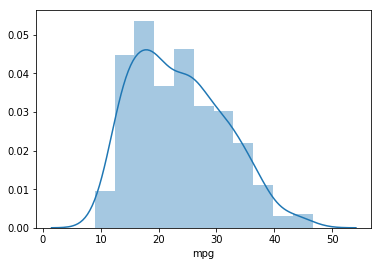

In [229]:
sns.distplot(new_df['mpg'],bins=11)

In [233]:
new_df.skew()

acceleration    0.278777
cylinders       0.526922
displacement    0.719645
horsepower      1.099113
model year      0.011535
mpg             0.457066
origin          0.923776
weight          0.531063
dtype: float64